In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from pgmpy.estimators import HillClimbSearch, BdeuScore, K2Score, BicScore
from pgmpy.estimators import BayesianEstimator

from matplotlib.pylab import plt
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

import seaborn as sns
sns.set(color_codes=True)

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

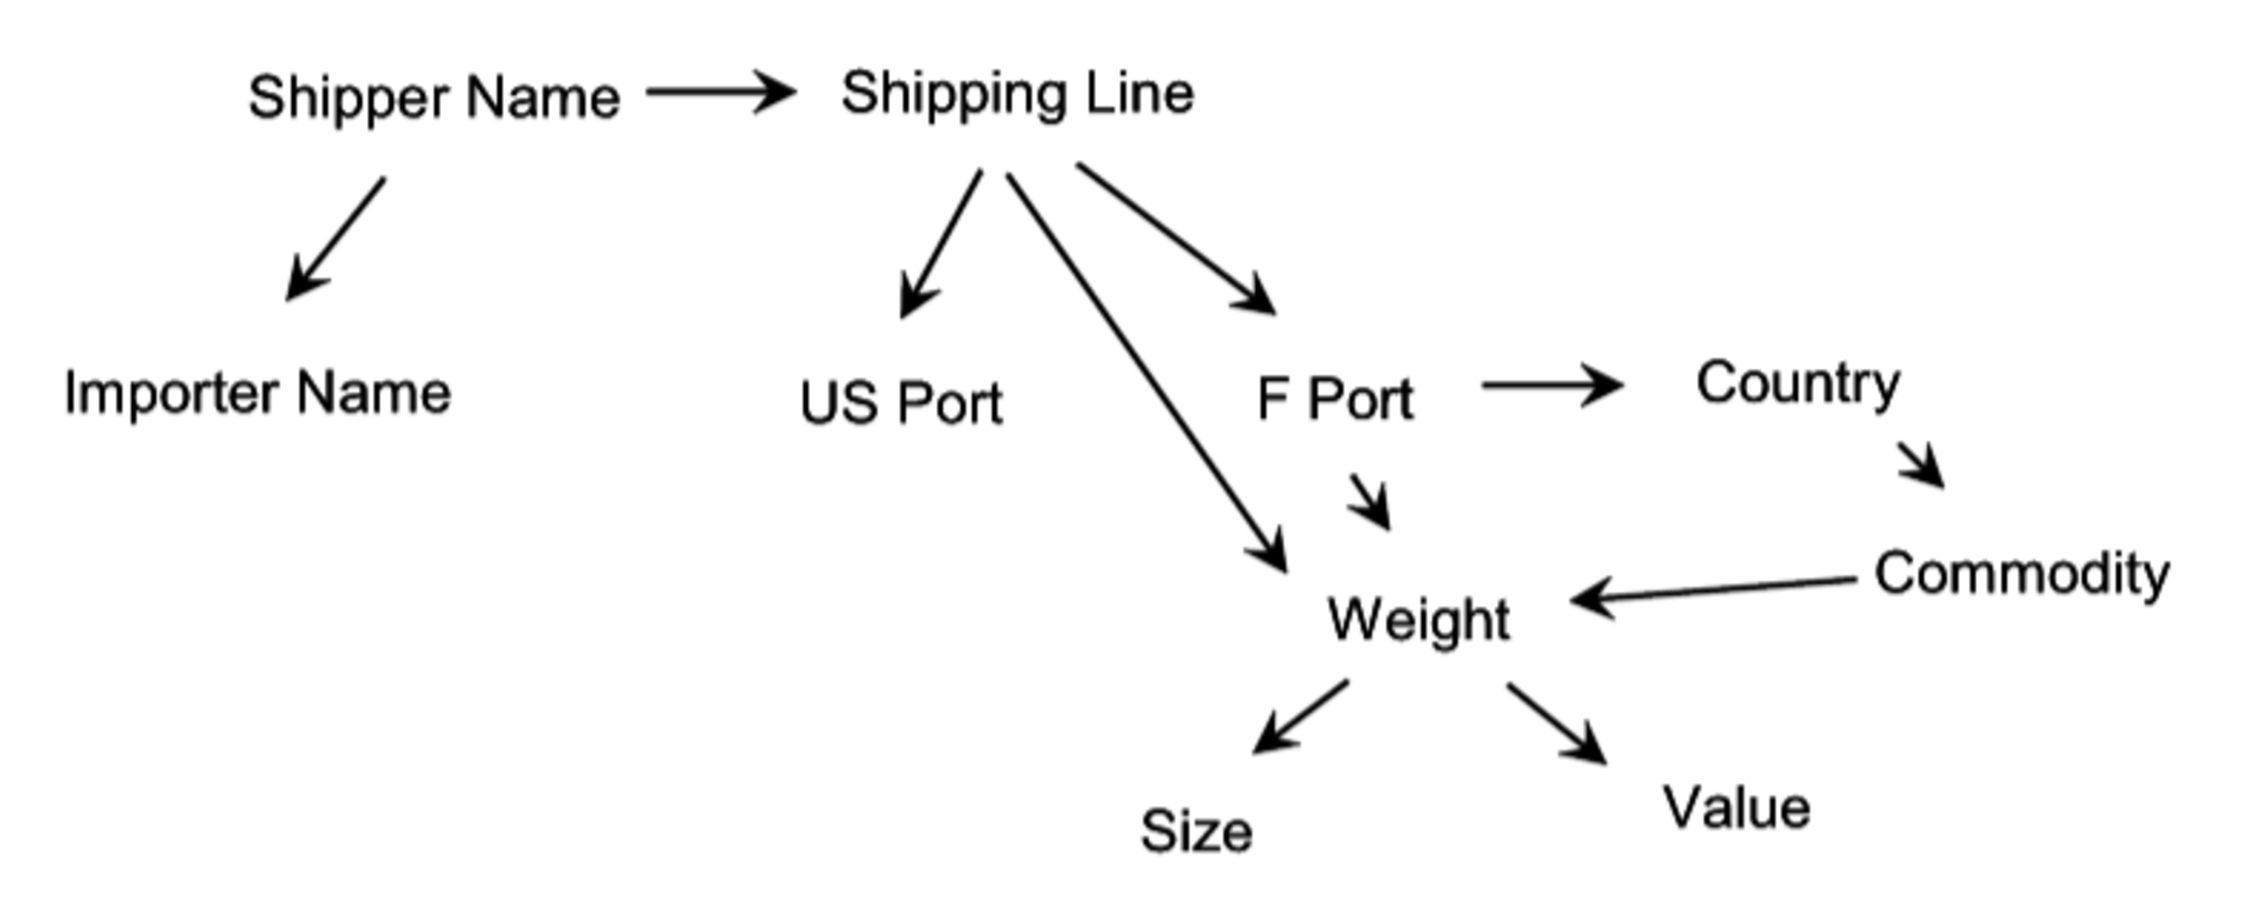

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? - **Dependent**

CI (Shipper Name, Value | Shipping Line)? - **Independent**

CI (Foreign Port, Commodity | Country)? - **Independent**

CI (Foreign Port, Commodity | Country, Weight)? - **Dependent**

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

*(Your answers here, including all calculations)*



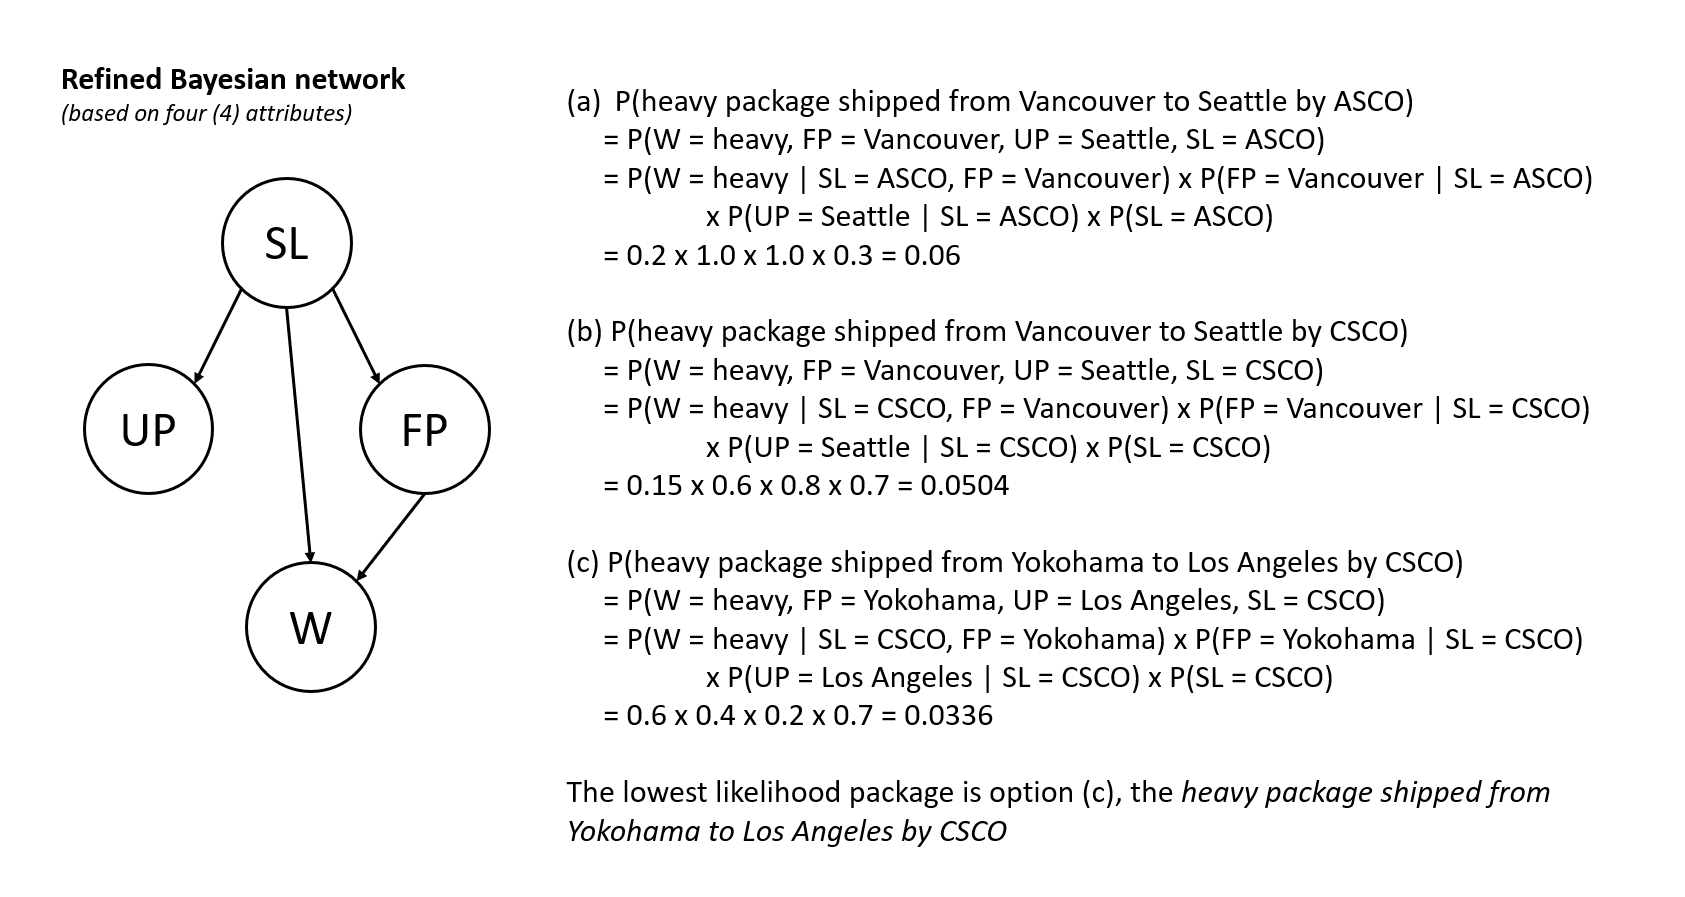

In [3]:
Image('HW3Q1.2.png')

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [4]:

data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,2,0,0,1,0,1
2,3,1,0,1,1,1
3,2,0,0,1,1,1
4,1,0,1,0,1,1


In [5]:
# your answers here

**a)** Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)


In [6]:
hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print(best_model.edges())

[('B', 'A'), ('D', 'A'), ('F', 'A')]


**b)** Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

In [7]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
print
print best_model.local_independencies(best_model.nodes())

CPD of A:
+------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
| B    | B(0)             | B(0)             | B(0)             | B(0)             | B(1)            | B(1)             | B(1)             | B(1)             |
+------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
| D    | D(0)             | D(0)             | D(1)             | D(1)             | D(0)            | D(0)             | D(1)             | D(1)             |
+------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
| F    | F(0)             | F(1)             | F(0)             | F(1)             | F(0)            | F(1)             | F(0)             | F(1)             |
+------+------------------+---

**c)** Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)  

In [8]:
predicted_train = best_model.predict(train.loc[:,"B":"F"])
print "In sample:",(train.loc[:,"A"]==predicted_train["A"]).mean()
predicted_test = best_model.predict(test.loc[:,"B":"F"])
print "Out of sample:",(test.loc[:,"A"]==predicted_test["A"]).mean()

In sample: 0.514
Out of sample: 0.5065


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [9]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [10]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


Cluster each of the 119 crimes into three (3) clusters using k-means clustering.

In [11]:
# Create dataframe with only hour of day attributes
X = data3.loc[:,'hour_0':'hour_23']

In [12]:
# Use k-means package from sklearn

km = KMeans(random_state=234,n_clusters=3)
res=km.fit(X)

print 'Cluster assignments:',res.labels_
print '\nCluster centers:\n',res.cluster_centers_
print '\nSum of squared errors:',res.inertia_


Cluster assignments: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 2 1 1 1 1 1 1 0 0 2 0 2 0 0 0 0 0 1 2 2 2 2 0 2 2 0 2 2 2 2 2 2 1 0 0
 1 1 0 2 2 1 1 2 1 1 0 0 2 1 2 1 0 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 2 0 0]

Cluster centers:
[[ 0.05364158  0.04182416  0.03691183  0.03104211  0.02510576  0.01886402
   0.01946212  0.02434162  0.02766839  0.0335171   0.03680552  0.03720506
   0.04254665  0.03994431  0.04208987  0.0473956   0.05170137  0.05425891
   0.05757893  0.05599685  0.0575726   0.05411778  0.05837336  0.0520345 ]
 [ 0.0424857   0.0124839   0.01063242  0.00917263  0.00935287  0.00782255
   0.01345328  0.02374573  0.05099082  0.09235549  0.07911561  0.06020408
   0.08877015  0.06328364  0.06309555  0.06824587  0.06216217  0.05215833
   0.04915732  0.04164785  0.03414496  0.02476704  0.02192139  0.01883064]
 [ 0.02578926  0.01492578  0.01124032  0.00610476  0.00276913  0.00135912
   0.00394105  0.00860188  0.01212724  0.02407099 

**a)** *Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster. (5 pts)*

In [13]:
cols = X.columns
dfCenters = pd.DataFrame(res.cluster_centers_, columns = cols)

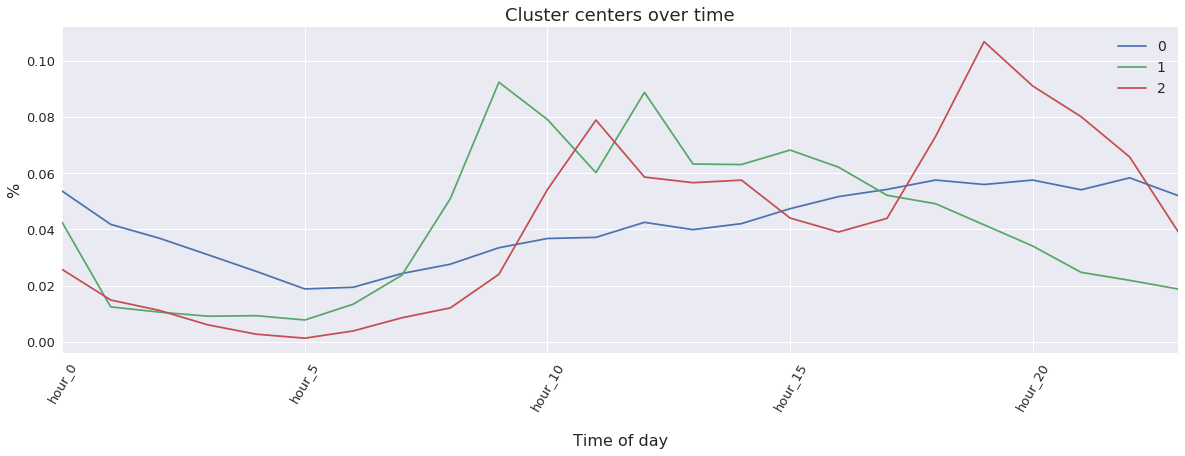

In [14]:

dfCenters.T.plot(figsize=(20,6));


plt.title('Cluster centers over time', fontsize = 18)
plt.xlabel('\nTime of day', fontsize = 16)
plt.ylabel('%', fontsize = 16)
plt.xticks(fontsize = 13, rotation=60)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 14);

**b)** *Describe the three different hour-of-day trends represented by these three clusters (5 pts).*

The blue cluster (cluster 0) is the most consistent throughout the day, with percentages fluctuating between approx. 0.055 and 0.02 across the day. All of the clusters have lower rates of crime in the morning, although the blue cluster has the highest proporation of crime of the three in the early morning hours.

Both the red (cluster 2) and green (cluster 1) clusters exhibit jagged peaks at different times during the day. The green line shows spike at 9am and 12noon. The red line has a spike around 11am, and at 7pm

**c)** *Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)*

In [15]:
for i in [0,1,2]:
    
    print("The value counts for crime categories for cluster " + str(i) + " are:" )
    print(data3.Category[res.labels_ == i].value_counts())
    print("")

The value counts for crime categories for cluster 0 are:
P2     34
P1V    24
P1P    11
Name: Category, dtype: int64

The value counts for crime categories for cluster 1 are:
P2     23
P1P     4
Name: Category, dtype: int64

The value counts for crime categories for cluster 2 are:
P2    23
Name: Category, dtype: int64



In [16]:
for i in [0,1,2]:
    
    print("The value counts for crime categories for cluster " + str(i) + " are:" )
    print(list(data3.crime_type[res.labels_ == i]))
    print("")

The value counts for crime categories for cluster 0 are:
['ARSON: BY FIRE', 'ASSAULT: AGG PO HANDS NO/MIN INJURY', 'ASSAULT: AGGRAVATED: HANDGUN', 'ASSAULT: AGGRAVATED: OTHER DANG WEAPON', 'ASSAULT: AGGRAVATED: OTHER FIREARM', 'ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR', 'ASSAULT: SIMPLE', 'BATTERY: AGG PO HANDS NO/MIN INJURY', 'BATTERY: AGG: HANDS/FIST/FEET NO/MINOR INJURY', 'BATTERY: AGG: HANDS/FIST/FEET SERIOUS INJURY', 'BATTERY: AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET SERIOUS INJURY', 'BATTERY: AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST', 'BATTERY: AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON', 'BATTERY: AGGRAVATED OF A SENIOR CITIZEN', 'BATTERY: AGGRAVATED: HANDGUN', 'BATTERY: AGGRAVATED: OTHER DANG WEAPON', 'BATTERY: AGGRAVATED:KNIFE/CUTTING INSTR', 'BATTERY: DOMESTIC BATTERY SIMPLE', 'BATTERY: SIMPLE', 'BURGLARY: ATTEMPT FORCIBLE ENTRY', 'BURGLARY: FORCIBLE ENTRY', 'BURGLARY: HOME INVASION', 'CRIM SEXUAL ASSAULT: AGGRAVATED: OTHER', 'CRIM SEXUAL ASSAULT: NON-AGGRAVATED

The common crimes found in cluster 0 are more aggressive (violent) crimes, motor vehicle theft, robbery, assault, burglary and crimes involving weapons. This clsuter was the one exhibiting the most consistent trends throughout the day.

Common crimes founds in cluster 1 are less violent and a good portion of white-collar crimes such as deception, making threats, identify theft, fraud and harrassment by telephone / electronic means.

Cluster 2 is predominantly drug offences, unregistered gun offenses and gambling. These are more likely to occur (or spike) at particular times during the day; and potentially less prevalent at night times.

**d)** *Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5 pts)*

In [17]:
data3.columns

Index([u'crime_type', u'Category', u'day_Sun', u'day_Mon', u'day_Tue',
       u'day_Wed', u'day_Thu', u'day_Fri', u'day_Sat', u'hour_0',
       ...
       u'community_area_68', u'community_area_69', u'community_area_70',
       u'community_area_71', u'community_area_72', u'community_area_73',
       u'community_area_74', u'community_area_75', u'community_area_76',
       u'community_area_77'],
      dtype='object', length=110)

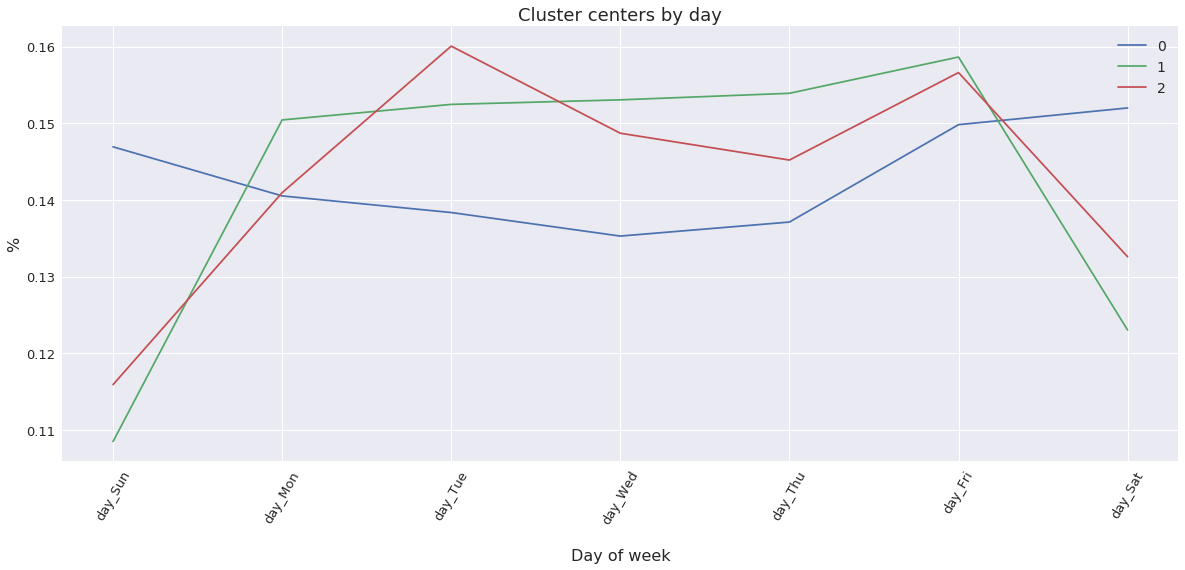

In [18]:
plt.figure(figsize=(20,8))
for i in [0,1,2]:
    
    plt.plot(data3.loc[:,'day_Sun':'day_Sat'][res.labels_ == i].mean(), label=i)

plt.title('Cluster centers by day', fontsize = 18)
plt.xlabel('\nDay of week', fontsize = 16)
plt.ylabel('%', fontsize = 16)
plt.xticks(fontsize = 13, rotation=60)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 14);

**e)** *Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)*

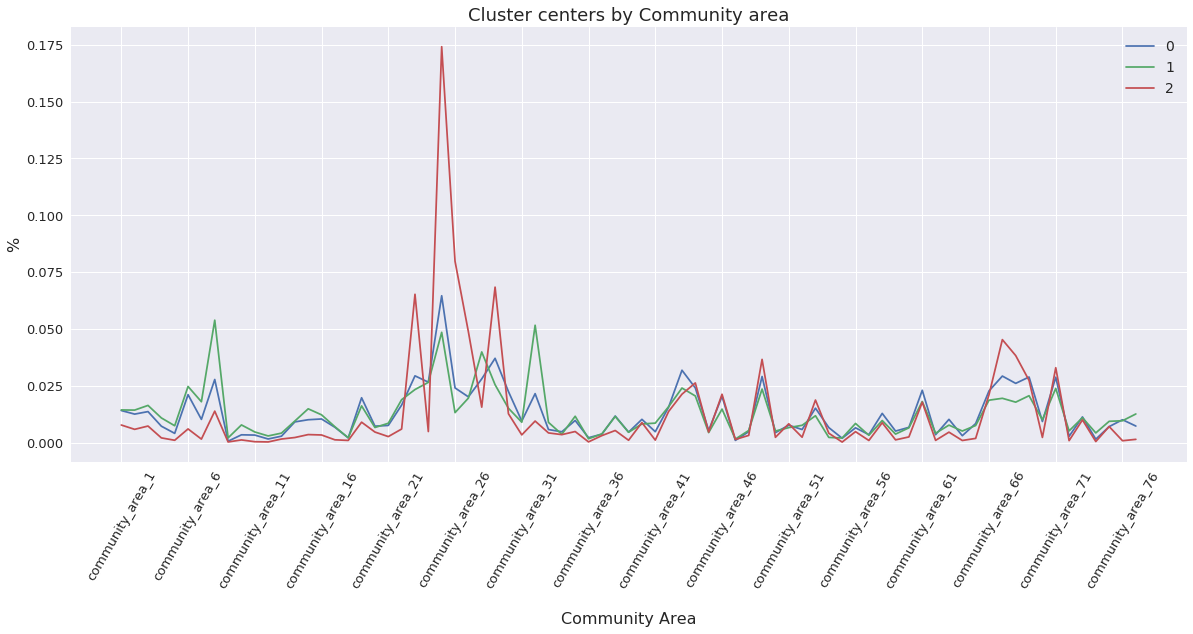

In [19]:
plt.figure(figsize=(20,8))

for i in [0,1,2]:
    
    plt.plot(data3.loc[:,'community_area_1':'community_area_77'][res.labels_ == i].mean(), label=i)

plt.xticks(range(0,77,5), rotation=60, fontsize=13)
plt.title('Cluster centers by Community area', fontsize = 18)
plt.xlabel('\nCommunity Area', fontsize = 16)
plt.ylabel('%', fontsize = 16)
plt.xticks(fontsize = 13, rotation=60)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 14);

In [20]:
demog = data4.loc[:,'PERCENT OF HOUSING CROWDED':'NUM_CRIMES_2016']

In [21]:
# Normalize demographic data
demog_normal = demog / demog.sum()

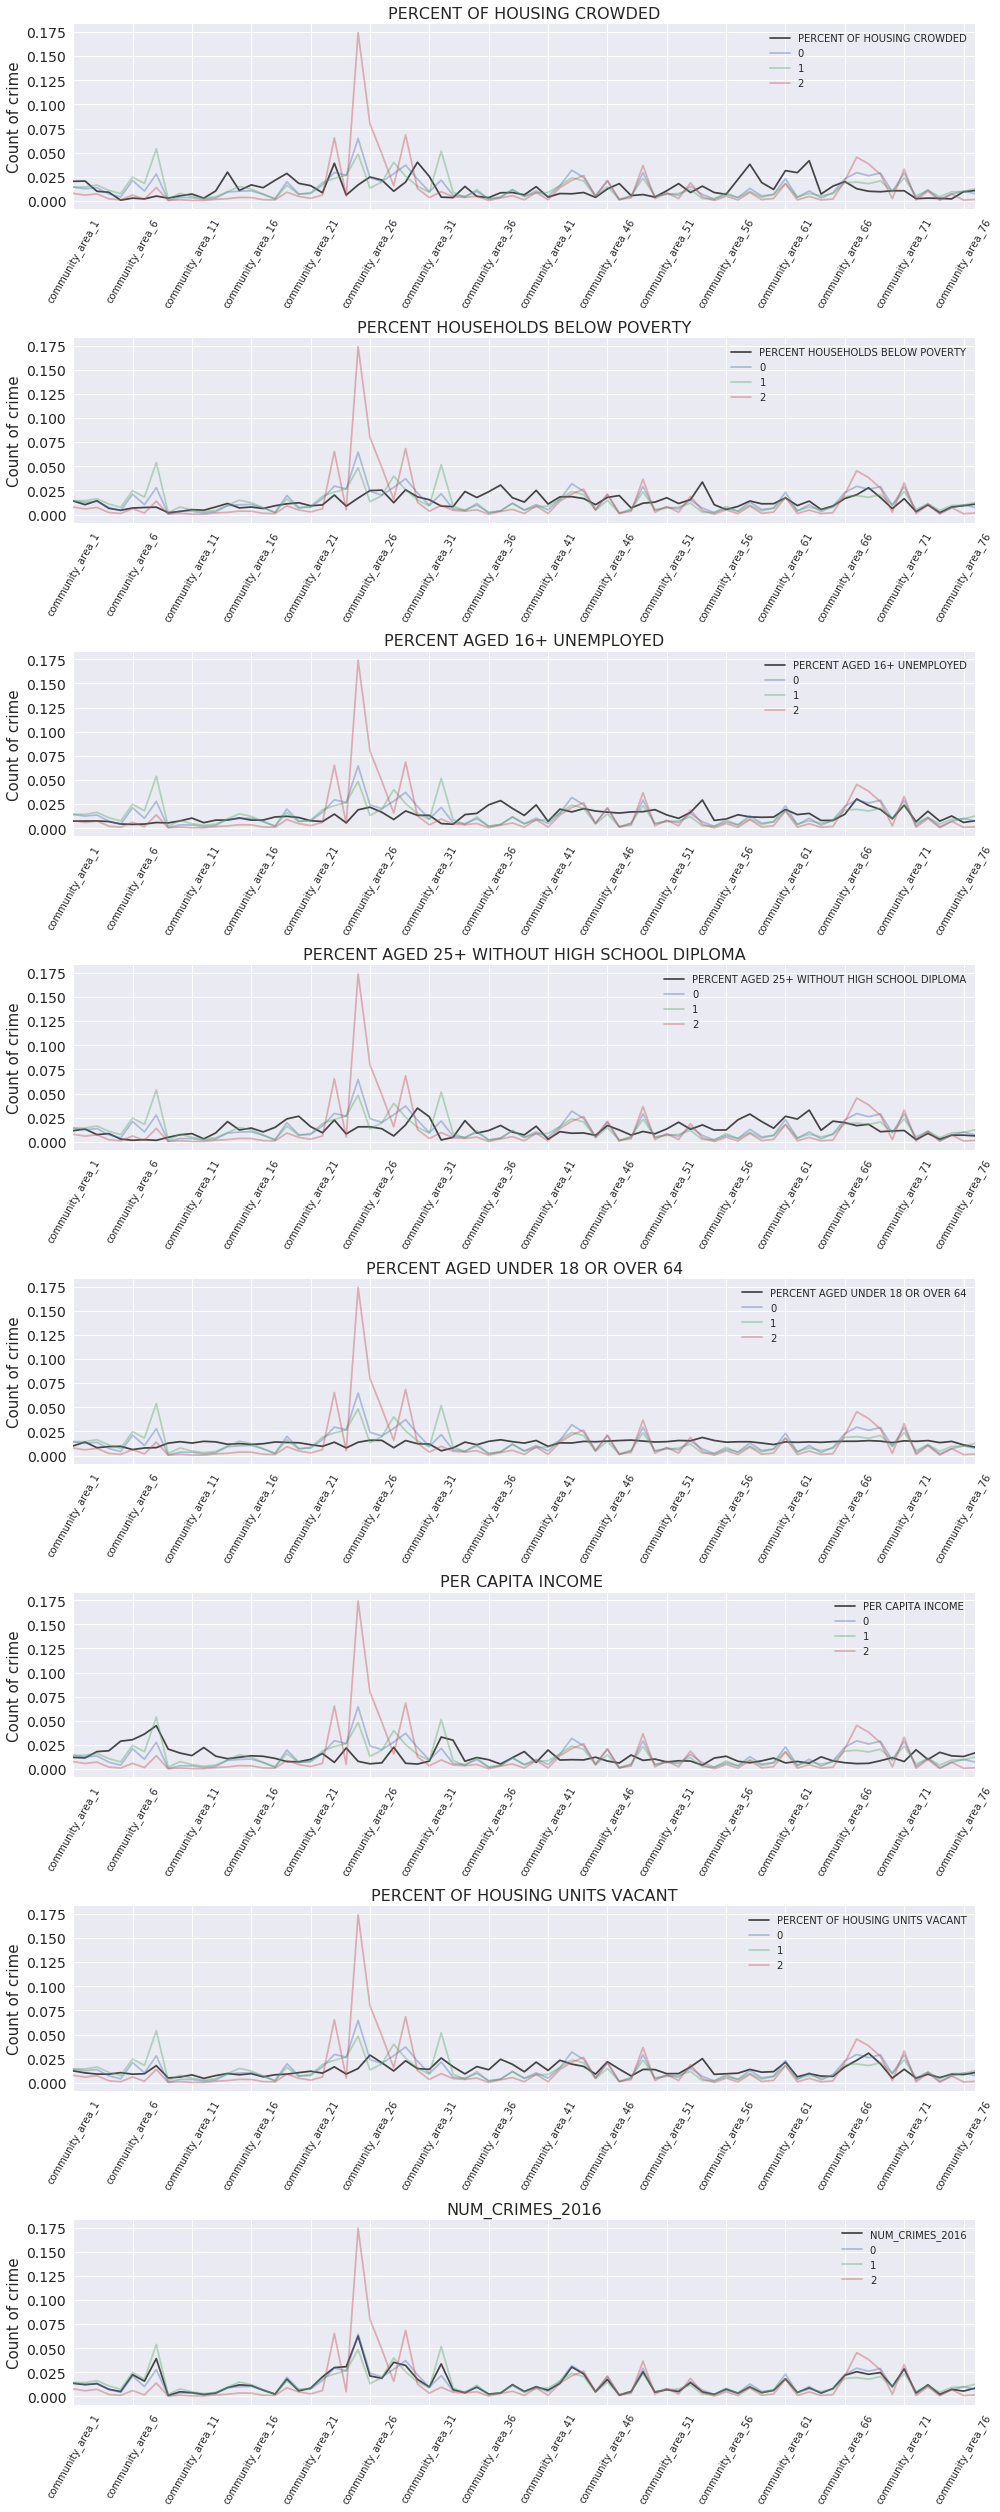

In [22]:
## Plot the demographic variables compared to the three (3) clusters

fig = plt.figure(figsize=(14, 35))

for i, lab in enumerate(demog):
   
    ax = fig.add_subplot(8, 1, (i + 1))
    demog_normal.loc[:,lab].plot(ax=ax, c='k', alpha = 0.8, label = lab)
  
    for p in [0,1,2]:
    
        ax.plot(data3.loc[:,'community_area_1':'community_area_77'][res.labels_ == p].mean(), label=p, alpha = 0.4)

    plt.xticks(range(0,77,5), rotation=60)
    plt.yticks(fontsize = 14)
    plt.ylabel('Count of crime', fontsize = 15)
    plt.title(lab, fontsize = 16)
    plt.legend()
    plt.tight_layout()
  

The above plots show demographic and community variables against clusters. There aren't greatly significant trends sown; although the variables showing the closest matching relationships to our three clusters across community areas are NUM_CRIMES_2016, PERCENT HOUSEHOLDS BELOW POVERTY and UNITS VACANT.  

**f)** *How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)*

In [23]:
for i in [0,1,2]:
    
    print("The value counts for crime categories for cluster " + str(i) + " are:" )
    print(data3.Category[res.labels_ == i].value_counts())
    print("")

The value counts for crime categories for cluster 0 are:
P2     34
P1V    24
P1P    11
Name: Category, dtype: int64

The value counts for crime categories for cluster 1 are:
P2     23
P1P     4
Name: Category, dtype: int64

The value counts for crime categories for cluster 2 are:
P2    23
Name: Category, dtype: int64



Cluster 0 is a mix of each of the FBI groups (P1V, P1P and P2). Cluster 1 is predominantly P2 crimes, and cluster 2 is all P2 crimes.

**g)** *For part g, you will use the same dataset to compare the clusters produced by several different methods. But this time you should cluster using only the day-of-week (not hour-of-day) attributes (day_Sun..day_Sat). Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric. In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify). For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)*

In [24]:
data3.columns

Index([u'crime_type', u'Category', u'day_Sun', u'day_Mon', u'day_Tue',
       u'day_Wed', u'day_Thu', u'day_Fri', u'day_Sat', u'hour_0',
       ...
       u'community_area_68', u'community_area_69', u'community_area_70',
       u'community_area_71', u'community_area_72', u'community_area_73',
       u'community_area_74', u'community_area_75', u'community_area_76',
       u'community_area_77'],
      dtype='object', length=110)

In [25]:
# Create dataframe with only day of week attributes
X = data3.loc[:,'day_Sun':'day_Sat']

*(i) k-means*

In [26]:
from sklearn.metrics import silhouette_score

# Choose a range of cluster numbers that you would like to evalulate:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    km = KMeans(random_state=234,n_clusters=n_clusters)
    res=km.fit(X)
    cluster_labels=res.labels_    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.235578596716
For n_clusters = 3, the average silhouette_score is : 0.217964397508
For n_clusters = 4, the average silhouette_score is : 0.226804792178
For n_clusters = 5, the average silhouette_score is : 0.234746671082
For n_clusters = 6, the average silhouette_score is : 0.168858595043
For n_clusters = 7, the average silhouette_score is : 0.164235452427
For n_clusters = 8, the average silhouette_score is : 0.162248445726
For n_clusters = 9, the average silhouette_score is : 0.159021401202


Maximize silhouette score => choose n=2 clusters

In [27]:
# Use k-means package from sklearn

km = KMeans(random_state=234,n_clusters=2)
res=km.fit(X)

print 'Cluster assignments:',res.labels_
print '\nCluster centers:\n',res.cluster_centers_
print '\nSum of squared errors:',res.inertia_


Cluster assignments: [0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1
 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0
 1 0 1 1 0 0 0 1]

Cluster centers:
[[ 0.1576468   0.13355294  0.13236912  0.12988896  0.13010015  0.15038767
   0.16605437]
 [ 0.10882903  0.15139904  0.15804707  0.15295634  0.15387092  0.15564056
   0.11925704]]

Sum of squared errors: 0.528951647439


In [28]:
#Store clsuter results in a dataframe
clusterings = pd.DataFrame (res.labels_, columns=["Kmeans"])

*(ii) Gaussian Mixture*

In [29]:
from sklearn.mixture import GaussianMixture
from scipy import linalg

# Choose a range of cluster numbers that you would like to evalulate:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters,random_state=100)
    res = gmm.fit(X)
    cluster_labels=res.predict(X)   
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))


For n_clusters = 2, the average silhouette_score is : 0.25672726757
For n_clusters = 3, the average silhouette_score is : 0.220138318719
For n_clusters = 4, the average silhouette_score is : 0.227039527208
For n_clusters = 5, the average silhouette_score is : 0.228181354752
For n_clusters = 6, the average silhouette_score is : 0.131900647716
For n_clusters = 7, the average silhouette_score is : 0.124568298065
For n_clusters = 8, the average silhouette_score is : 0.0926766174968
For n_clusters = 9, the average silhouette_score is : 0.131345891873


Select n=2 clusters as this maximizes silhouette score.

In [30]:

gmm = GaussianMixture(n_components=2,random_state=100)
res = gmm.fit(X)

print 'Clusters\n',res.predict(X)
print '\nCluster centers:\n',res.means_
print '\nCluster covariances:\n',res.covariances_
print '\nLog-likelihood per sample:',res.score(X)

Clusters
[0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 1]

Cluster centers:
[[ 0.14374577  0.14214832  0.13882126  0.13809564  0.13851687  0.14902967
   0.14964246]
 [ 0.10306846  0.14462626  0.16324958  0.15153884  0.15251181  0.1634716
   0.12153345]]

Cluster covariances:
[[[  8.98391608e-04  -2.86964722e-04  -3.47778423e-04  -2.53203804e-04
    -3.19504798e-04  -2.95311159e-05   3.39591254e-04]
  [ -2.86964722e-04   4.71788785e-04   1.91080467e-04   2.03066079e-04
     1.14754236e-04  -2.72519798e-04  -4.20205046e-04]
  [ -3.47778423e-04   1.91080467e-04   4.17353333e-04   1.84714799e-04
     1.86023991e-04  -2.15651147e-04  -4.14743020e-04]
  [ -2.53203804e-04   2.03066079e-04   1.84714799e-04   3.44041817e-04
     1.41019774e-04  -1.88784867e-04  -4.29853797e-04]
  [ -3.19504798e-04   1.14

In [31]:
clusterings['GMM'] = res.predict(X)

*(iii) Single Linkage Bottom Up Hierarchical*

In [32]:
from sklearn.metrics import silhouette_score

# Choose a range of cluster numbers that you would like to evalulate:
range_n_clusters = range(2,10)
Z = linkage(X, 'single')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.637764808067
For n_clusters = 3, the average silhouette_score is : 0.556847738297
For n_clusters = 4, the average silhouette_score is : 0.40557775076
For n_clusters = 5, the average silhouette_score is : 0.387703818875
For n_clusters = 6, the average silhouette_score is : 0.390076195102
For n_clusters = 7, the average silhouette_score is : 0.346218448204
For n_clusters = 8, the average silhouette_score is : 0.328998157644
For n_clusters = 9, the average silhouette_score is : 0.325421927489


Maximize silhouette score with n = 2 again.

In [33]:
SingleClusters = fcluster(Z, 2, criterion='maxclust')
SingleClusters = SingleClusters - 1
print(SingleClusters)

clusterings['singlelink'] = SingleClusters

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


*(iv) Complete-link Bottom Up Hierarchical*

In [34]:
from sklearn.metrics import silhouette_score

# Choose a range of cluster numbers that you would like to evalulate:
range_n_clusters = range(2,10)
Z = linkage(X, 'complete')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.610064611355
For n_clusters = 3, the average silhouette_score is : 0.172687181466
For n_clusters = 4, the average silhouette_score is : 0.192151693748
For n_clusters = 5, the average silhouette_score is : 0.150252078225
For n_clusters = 6, the average silhouette_score is : 0.152296815722
For n_clusters = 7, the average silhouette_score is : 0.149262676161
For n_clusters = 8, the average silhouette_score is : 0.101304401234
For n_clusters = 9, the average silhouette_score is : 0.100665038992


Silhouette score is maximized for complete link with n = 2.

In [35]:
CompleteClusters = fcluster(Z, 2, criterion='maxclust')
CompleteClusters = CompleteClusters - 1
print(CompleteClusters)

clusterings['completelink'] = CompleteClusters

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


In [37]:
for j in clusterings.columns:
    print("For " + str(j))
    for i in [0,1]:    
        print("The number of crimes for cluster " + str(i) + " is: " + str(len(clusterings[clusterings[j]==i]))) 
       # print(len(clusterings[clusterings[j]==i]))
    print("")

For Kmeans
The number of crimes for cluster 0 is: 57
The number of crimes for cluster 1 is: 62

For GMM
The number of crimes for cluster 0 is: 89
The number of crimes for cluster 1 is: 30

For singlelink
The number of crimes for cluster 0 is: 118
The number of crimes for cluster 1 is: 1

For completelink
The number of crimes for cluster 0 is: 2
The number of crimes for cluster 1 is: 117



In [38]:
clusterings.head()

,Kmeans,GMM,singlelink,completelink
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,1,0,1


The clusters formed using Kmeans and Gaussian Mixture appear to be of similar sizes. For the hierarchical methods, they identify 1 (single link) or 2 (complete link) outliers, and lump the rest of the crimes in another cluster.